# Backward Movement 

In [1]:
from flygym.mujoco.arena import BaseArena, FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

from gymnasium.utils.env_checker import check_env

from IPython.display import Video
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed
from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

To implement the backward movement of the fly in a hybrid turning neuromechfly, we have reused the method observed in the exercise session of the class [Controlling Behavior in Animals and Robots (BIOENG-456)](https://edu.epfl.ch/coursebook/en/controlling-behavior-in-animals-and-robots-BIOENG-456).

The backward movement simulation for a fly, using the `flygym.mujoco` package, involves several key steps:

1. **Setup Simulation Parameters**: Initialize the simulation with specific settings such as runtime, rendering modes, and other configurations using `flygym.mujoco.Parameters`.

2. **Load Joint Data**: Import pre-recorded data from a pickle file that includes joint movements of the fly. This dataset serves as the foundational template for the simulation.

3. **Interpolate Joint Data**: Adjust the joint angles data to match the simulation’s timeframe through interpolation, utilizing `numpy.interp()`, to fit the data into the desired number of steps.

4. **Detect Movement Peaks**: Utilize `scipy.signal.find_peaks` to identify peaks in the tibia angle of the right hind leg, pinpointing significant points in the movement cycle.

5. **Extract Movement Cycles**: Calculate the average cycle length and extract specific movement cycles based on the detected peaks, isolating repetitive patterns of movement.

6. **Generate Backward Movement**: Simulate backward movement by reversing the order of frames in each cycle. This approach is suggested in the commented line `# data_block_backwards = data_block_backwards[:, ::-1]`, which reverses the time series data to simulate backward motion.

7. **Reassign Joint Angles for Backward Motion**: Manipulate the joint angles to enhance realism in backward motion by reassigning angles based on a predefined leg mapping (e.g., left front to right hind) and rescaling them to match the joint angles of the corresponding leg.

8. **Update Simulation Parameters**: Adjust the simulation settings once more, likely to optimize the visualization and playback speed of the backward movement.

This method efficiently uses joint data manipulation along with interpolation and peak detection to realistically simulate and visualize backward motion in a virtual fly model.

**Furthermore**, it is crucial to note that this method was implemented by invoking the `step` function of the original `NeuroMechFly` class from `core.py`. For our project, where we aim to utilize backward movement in a `HybridTurningNMF` class, we have enhanced the `step` function with an additional argument, `def step(self, action, original_action=False):`. This modification allows the fly to perform backward movements with the original step function when `original_action` is set to `True` in a `HybridTurningNMF`.


In [5]:
# codes copy-pasted from the exercise
# ===============================================================================================
run_time = 1
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, render_mode="saved", render_playspeed=0.2, draw_contacts=True
)
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, dof in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[dof])

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

data_block_backwards = data_block_cycle.copy()
# data_block_backwards = data_block_backwards[:, ::-1]  # reverse the order of the frames

for i, (dof, angles) in enumerate(zip(actuated_joints, data_block_cycle)):
    # reassign the joint angles
    # (LF -> RH, RF -> LH, LM -> RM, RM -> LM, LH -> RF, RH -> LF)
    orig_dof = dof.translate(str.maketrans("LRFH", "RLHF"))[:8] + dof[8:]
    orig_angles = data_block_cycle[actuated_joints.index(orig_dof)]
    # rescale to match the range of the joint angles of that leg
    data_block_backwards[i] = (
        orig_angles - orig_angles.min()
    ) / orig_angles.ptp() * angles.ptp() + angles.min()

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, 
    render_mode="saved", 
    render_playspeed=0.1, 
    draw_contacts=False,
)
# ===============================================================================================

In [6]:
# ===============================================================================================
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    # obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.5,
    # obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

# create nmf with the backward movement
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
)
obs_hist = []
obs, info = nmf.reset()
for i in trange(target_num_steps):
    joint_pos = data_block_backwards[:, i % cycle_n_frames]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action, True)
    obs_hist.append(obs)
    nmf.render()
# ===============================================================================================

# for the visualization
nmf.save_video("./outputs/backwards_hybrid.mp4")
Video("./outputs/backwards_hybrid.mp4")

100%|██████████| 10000/10000 [03:01<00:00, 55.12it/s]


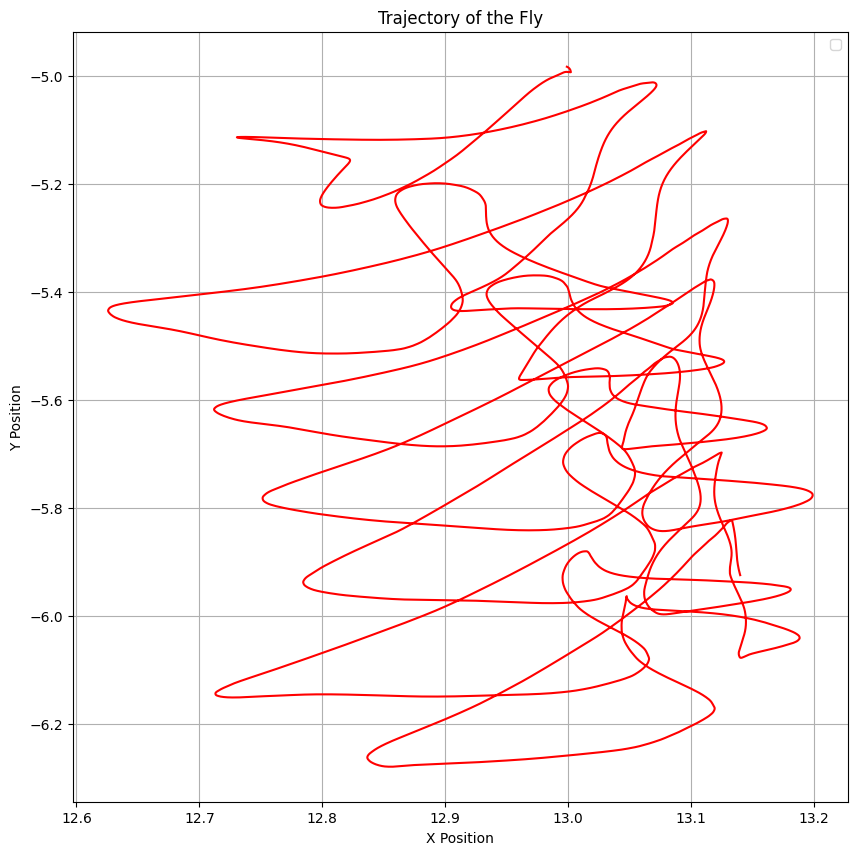

In [7]:
# Plot the trajectory of the fly
plt.figure(figsize=(10, 10))

plt.plot(np.array([obs["fly"][0] for obs in obs_hist])[:, 0], np.array([obs["fly"][0] for obs in obs_hist])[:, 1], color='red')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory of the Fly")
plt.grid(True)
plt.legend()
plt.show()

**Comment :** In this scenario, the fly starts at the spawn position (13, -5). The plot clearly shows that the fly is moving backward, but there is also a slight movement to the right.